# Desafío de NLP - PhawAI 2025
### Nombre: Annabella Noelia Sánchez Guzmán

## Setup

In [53]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
import numpy as np

## Carga y preprocesamiento de datos

In [7]:

# Cargar los archivos TSV (train, dev, test)
train_data = pd.read_csv('train.tsv', sep='\t')
dev_data = pd.read_csv('dev.tsv', sep='\t')
test_data = pd.read_csv('test.tsv', sep='\t')

# Verificar que se cargaron correctamente
print(train_data.head())
print(dev_data.head())
print(test_data.head())

                               id          event  \
0  3B9XR6P1WE1U78OX08FW8NXJL93BJG      NotreDame   
1  3P4ZBJFX2V96Q90CC9K7G3IC235WFF      Venezuela   
2  3IQ9O0AYW65Y8JY8ICLHWGO5E1JIT6         LaLiga   
3  3XEIP58NL0TWKWFD977CAKHEG1ZLZ3         LaLiga   
4  3BFNCI9LYKWWKIJIK6BTNEUY6MU37E  GretaThunberg   

                                               tweet offensive emotion  
0  I know that the Notre Dame is a very important...        NO  others  
1  #BREAKING:  (USER) -- Trump threatens `full an...        NO  others  
2  #Barcelona will win La Liga with three games t...        NO  others  
3  HT: Decent half. A goal would've been good tho...        NO  others  
4  In the 20th century we had weeping statues of ...        NO  others  
                               id            event  \
0  3AXFSPQOYQ4KKP0D5A1SRDO407VFJ2        NotreDame   
1  3MNJFORX8BACDQLSG8XYQ35ZI655FB    GameOfThrones   
2  3BFF0DJK8XIN2X14NOFV0IUSNZGTS4        NotreDame   
3  3QX22DUVOONZHUSO8MJOPRJ7SVHVMD

In [39]:
# Ver la distribución de clases en y_train
class_distribution = pd.Series(y_train).value_counts()

print("Distribución de clases en y_train:")
print(class_distribution)


Distribución de clases en y_train:
4    2313
3    1427
1     536
5     291
0     274
6     165
2     106
Name: count, dtype: int64


In [8]:
# Descargar stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Función de limpieza de texto
def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = ''.join([c for c in text if c.isalpha() or c.isspace()])  # Eliminar puntuación
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Eliminar stopwords
    return text

# Limpiar los tweets de los datasets
train_data['cleaned_text'] = train_data['tweet'].apply(clean_text)
dev_data['cleaned_text'] = dev_data['tweet'].apply(clean_text)
test_data['cleaned_text'] = test_data['tweet'].apply(clean_text)

# Verifica el resultado
print(train_data[['tweet', 'cleaned_text']].head())

                                               tweet  \
0  I know that the Notre Dame is a very important...   
1  #BREAKING:  (USER) -- Trump threatens `full an...   
2  #Barcelona will win La Liga with three games t...   
3  HT: Decent half. A goal would've been good tho...   
4  In the 20th century we had weeping statues of ...   

                                        cleaned_text  
0  know notre dame important landmark fact billio...  
1  breaking user trump threatens full complete em...  
2  barcelona win la liga three games spare beat l...  
3  ht decent half goal wouldve good though fcbliv...  
4  th century weeping statues virgin mary weve go...  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
# Codificar las etiquetas de emociones
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['emotion'])
y_dev = label_encoder.transform(dev_data['emotion'])
y_test = label_encoder.transform(test_data['emotion'])

# Verificar que las etiquetas se han convertido correctamente
print(y_train[:10])

[4 4 4 4 4 4 4 4 1 4]


In [40]:
print(label_encoder.classes_)

['anger' 'disgust' 'fear' 'joy' 'others' 'sadness' 'surprise']


In [47]:
# Tokenización y secuenciación
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['cleaned_text'])

# Convertir textos a secuencias de enteros
X_train = tokenizer.texts_to_sequences(train_data['cleaned_text'])
X_dev = tokenizer.texts_to_sequences(dev_data['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test_data['cleaned_text'])

# Rellenar secuencias a un tamaño fijo
max_len = 50  # Ajusta según el largo promedio de tus textos
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_dev = pad_sequences(X_dev, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# Verificar las dimensiones de las entradas
print(X_train.shape, X_dev.shape, X_test.shape)

(5112, 50) (744, 50) (1447, 50)


In [48]:
# Crear el objeto SMOTE para oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Aplicar SMOTE para generar ejemplos sintéticos para las clases minoritarias
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verificar el balance de clases después del oversampling
print(pd.Series(y_train_res).value_counts())


4    2313
1    2313
3    2313
0    2313
5    2313
6    2313
2    2313
Name: count, dtype: int64


## Entrenamiento de modelos

### Modelo 1: RNN con LSTM

In [60]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))  # Capa de embeddings
model_lstm.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))  # LSTM con Dropout
model_lstm.add(Dense(128, activation='relu'))  # Capa densa
model_lstm.add(Dense(8, activation='softmax'))  # 8 categorías (emociones)

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compilación del modelo
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento del modelo con EarlyStopping
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev), callbacks=[early_stopping])


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.4055 - loss: 1.6478 - val_accuracy: 0.4530 - val_loss: 1.4698
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.4456 - loss: 1.4851 - val_accuracy: 0.4530 - val_loss: 1.4637
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.4530 - loss: 1.4836 - val_accuracy: 0.4530 - val_loss: 1.4683
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.4635 - loss: 1.4475 - val_accuracy: 0.4530 - val_loss: 1.4640
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.4478 - loss: 1.4851 - val_accuracy: 0.4530 - val_loss: 1.4634
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.4560 - loss: 1.4460 - val_accuracy: 0.4530 - val_loss: 1.4688
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.4386 - loss: 1.4887 - val_accuracy: 0.4530 - val_loss: 1.4617
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.4649 - loss: 1.4513 - val_accuracy: 0

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


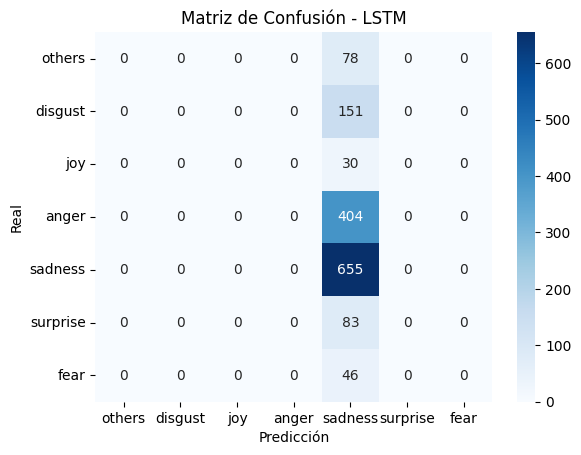

              precision    recall  f1-score   support

      others       0.00      0.00      0.00        78
     disgust       0.00      0.00      0.00       151
         joy       0.00      0.00      0.00        30
       anger       0.00      0.00      0.00       404
     sadness       0.45      1.00      0.62       655
    surprise       0.00      0.00      0.00        83
        fear       0.00      0.00      0.00        46

    accuracy                           0.45      1447
   macro avg       0.06      0.14      0.09      1447
weighted avg       0.20      0.45      0.28      1447



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [61]:
# Evaluar el modelo LSTM
y_pred_lstm = model_lstm.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_lstm.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data['emotion'].unique(), yticklabels=train_data['emotion'].unique())
plt.title('Matriz de Confusión - LSTM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred_lstm.argmax(axis=1), target_names=train_data['emotion'].unique()))


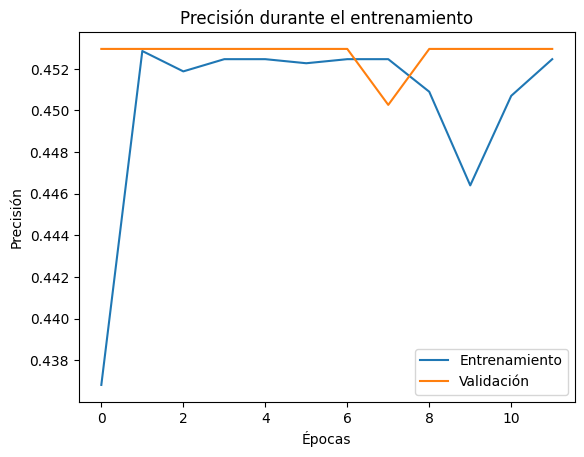

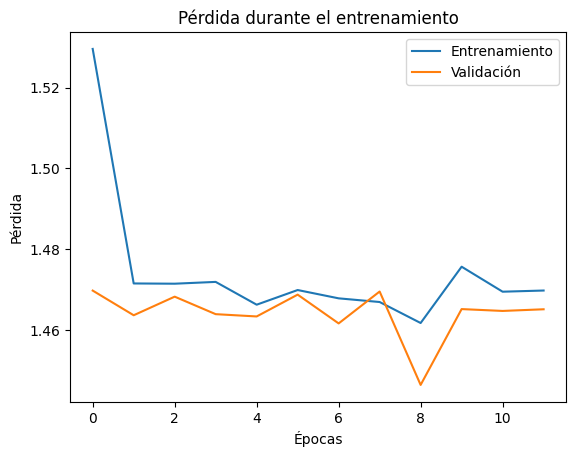

In [62]:
# Graficar la precisión durante el entrenamiento
plt.plot(history_lstm.history['accuracy'], label='Entrenamiento')
plt.plot(history_lstm.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida durante el entrenamiento
plt.plot(history_lstm.history['loss'], label='Entrenamiento')
plt.plot(history_lstm.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### Análisis
**Rendimiento por Emoción:**

Sadness (655): Recall 100%, pero solo porque el modelo predice únicamente esta clase

Anger (404): Recall 0% - todas clasificadas como sadness

Others (78): Recall 0% - todas clasificadas como sadness

Disgust (151): Recall 0% - todas clasificadas como sadness

Surprise (83): Recall 0% - todas clasificadas como sadness

Fear (46): Recall 0% - todas clasificadas como sadness

Joy (30): Recall 0% - todas clasificadas como sadness

**Curvas de Entrenamiento (Mejoradas)**
Precisión:

Entrenamiento:

Convergencia rápida a aprox 45.2% en la primera época, se mantiene estable
Validación: Muy estable durante todo el entrenamiento (aprox 45.2%), con ligera caída en época 8

Pérdida:

Entrenamiento:

Caída inicial pronunciada (1.53 -> 1.47), luego estabilización
Validación: Comportamiento muy estable (~1.467), indicando no hay overfitting

Interpretación

El modelo LSTM converge muy rápidamente a una estrategia simple: predecir siempre sadness (45% de las muestras). Esta estrategia le da una precisión del 45% sin esfuerzo, y el modelo no encuentra incentivo para aprender patrones más complejos.

### Modelo 2: CNN

In [63]:
# Crear el modelo CNN con Dropout y Regularización
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))  # Capa de embeddings
model_cnn.add(Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Regularización L2
model_cnn.add(MaxPooling1D(pool_size=2))  # Capa de max pooling
model_cnn.add(Dropout(0.5))  # Añadir Dropout con una tasa de 0.5
model_cnn.add(Flatten())  # Aplanar para pasar a la capa densa
model_cnn.add(Dense(128, activation='relu'))  # Capa densa
model_cnn.add(Dense(8, activation='softmax'))  # 8 categorías (emociones)

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compilación del modelo
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento del modelo con EarlyStopping
history = model_cnn.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_dev, y_dev), callbacks=[early_stopping])


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.4225 - loss: 2.3315 - val_accuracy: 0.5094 - val_loss: 1.4760
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5176 - loss: 1.3693 - val_accuracy: 0.5228 - val_loss: 1.3182
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6073 - loss: 1.1118 - val_accuracy: 0.5108 - val_loss: 1.3472
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7108 - loss: 0.8853 - val_accuracy: 0.5067 - val_loss: 1.4864
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7574 - loss: 0.7727 - val_accuracy: 0.5054 - val_loss: 1.7382


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


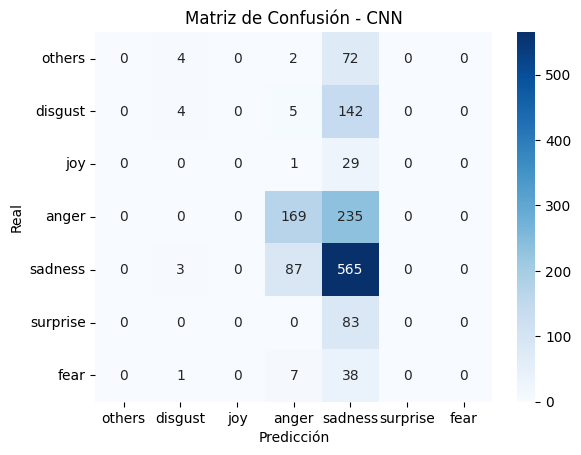

              precision    recall  f1-score   support

      others       0.00      0.00      0.00        78
     disgust       0.33      0.03      0.05       151
         joy       0.00      0.00      0.00        30
       anger       0.62      0.42      0.50       404
     sadness       0.49      0.86      0.62       655
    surprise       0.00      0.00      0.00        83
        fear       0.00      0.00      0.00        46

    accuracy                           0.51      1447
   macro avg       0.21      0.19      0.17      1447
weighted avg       0.43      0.51      0.43      1447



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [64]:
# Evaluar el modelo CNN
y_pred_cnn = model_cnn.predict(X_test)

# Matriz de confusión
cm_cnn = confusion_matrix(y_test, y_pred_cnn.argmax(axis=1))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=train_data['emotion'].unique(), yticklabels=train_data['emotion'].unique())
plt.title('Matriz de Confusión - CNN')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred_cnn.argmax(axis=1), target_names=train_data['emotion'].unique()))


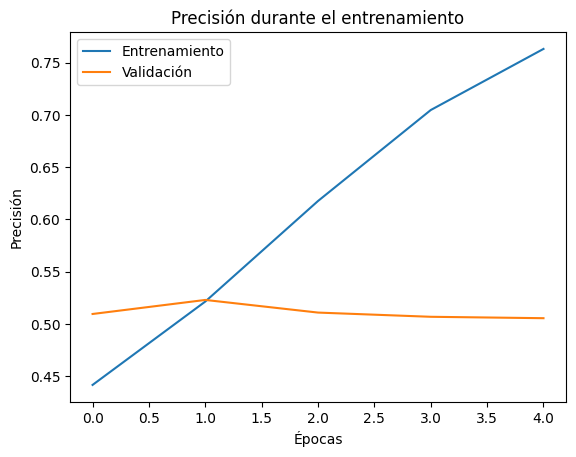

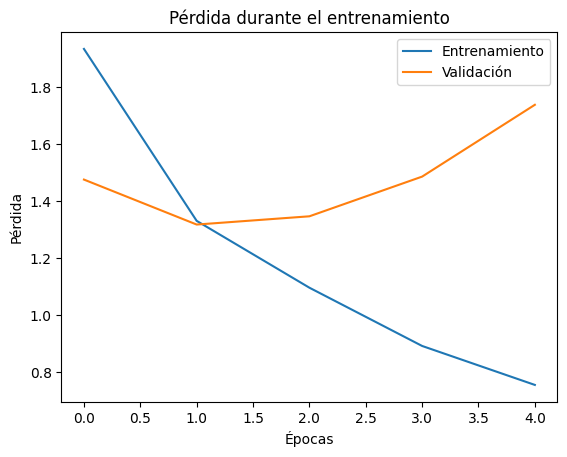

In [65]:
# Graficar la precisión durante el entrenamiento
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### Análisis
**Rendimiento por Emoción:**

Others (78): 0 correctas - todas mal clasificadas (4 disgust, 2 anger, 72 sadness)

Disgust (151): 0 correctas - todas mal clasificadas (4 disgust, 5 anger, 142 sadness)

Joy (30): 0 correctas - todas mal clasificadas (1 anger, 29 sadness)

Anger (404): 169 correctas, 235 clasificadas como sadness

Sadness (655): 565 correctas, algunas errores (3 disgust, 87 anger)

Surprise (83): 0 correctas - todas clasificadas como sadness (83)

Fear (46): 0 correctas - todas mal clasificadas (1 disgust, 7 anger, 38 sadness)

**Interpretación**

Similar al LSTM pero menos severo - el modelo se sesga fuertemente hacia sadness y anger, ignorando completamente las clases minoritarias. Es una mejora marginal sobre el LSTM que solo predecía sadness.

### Modelo 3: MLP (Perceptrón Multicapa)

In [66]:
# Crear el modelo MLP (Multilayer Perceptron) con Dropout
model_mlp = Sequential()
model_mlp.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))  # Capa de embeddings
model_mlp.add(Flatten())  # Aplanar para pasar a la capa densa
model_mlp.add(Dense(128, activation='relu'))  # Capa densa
model_mlp.add(Dropout(0.5))  # Añadir Dropout
model_mlp.add(Dense(64, activation='relu'))  # Otra capa densa
model_mlp.add(Dense(8, activation='softmax'))  # 8 categorías (emociones)

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compilación del modelo
model_mlp.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento del modelo con EarlyStopping
history_mlp = model_mlp.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_dev, y_dev), callbacks=[early_stopping])


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4233 - loss: 1.6332 - val_accuracy: 0.4691 - val_loss: 1.4214
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4909 - loss: 1.3689 - val_accuracy: 0.5161 - val_loss: 1.2956
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6123 - loss: 1.0540 - val_accuracy: 0.5094 - val_loss: 1.3490
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7822 - loss: 0.6236 - val_accuracy: 0.4919 - val_loss: 1.6065
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8907 - loss: 0.3297 - val_accuracy: 0.4973 - val_loss: 1.9405


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


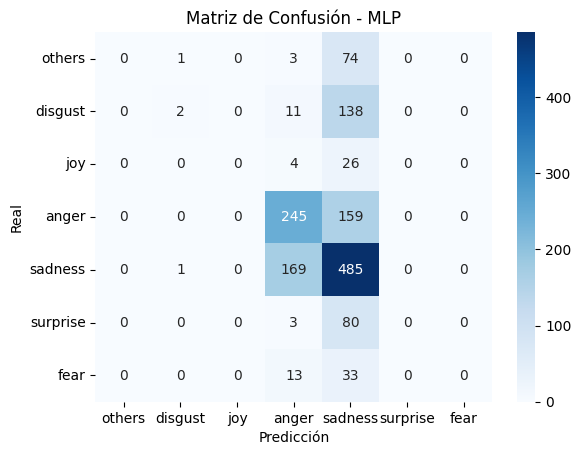

              precision    recall  f1-score   support

      others       0.00      0.00      0.00        78
     disgust       0.50      0.01      0.03       151
         joy       0.00      0.00      0.00        30
       anger       0.55      0.61      0.58       404
     sadness       0.49      0.74      0.59       655
    surprise       0.00      0.00      0.00        83
        fear       0.00      0.00      0.00        46

    accuracy                           0.51      1447
   macro avg       0.22      0.19      0.17      1447
weighted avg       0.43      0.51      0.43      1447



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [67]:
# Evaluar el modelo MLP
y_pred_mlp = model_mlp.predict(X_test)

# Matriz de confusión
cm_mlp = confusion_matrix(y_test, y_pred_mlp.argmax(axis=1))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=train_data['emotion'].unique(), yticklabels=train_data['emotion'].unique())
plt.title('Matriz de Confusión - MLP')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred_mlp.argmax(axis=1), target_names=train_data['emotion'].unique()))


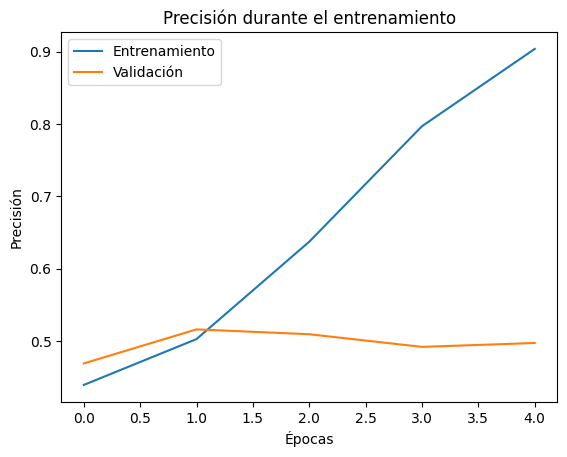

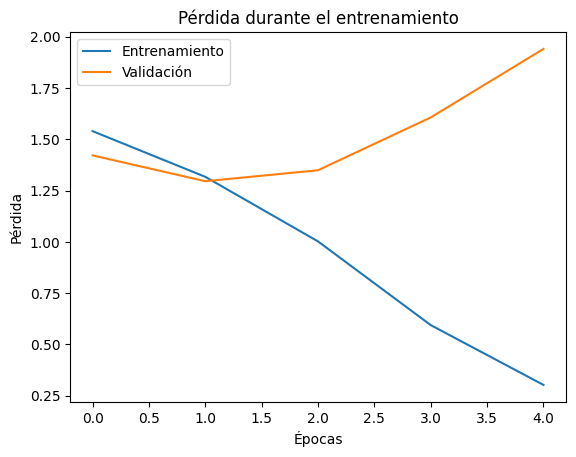

In [69]:
plt.plot(history_mlp.history['accuracy'], label='Entrenamiento')
plt.plot(history_mlp.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida durante el entrenamiento
plt.plot(history_mlp.history['loss'], label='Entrenamiento')
plt.plot(history_mlp.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### Análisis
**Rendimiento por Emoción (Recall):**

Others (78): 0/78 = 0% - Todas mal clasificadas (1 disgust, 3 anger, 74 sadness)

Disgust (151): 2/151 = 1.3% - Casi todas mal clasificadas (11 anger, 138 sadness)

Joy (30): 0/30 = 0% - Todas mal clasificadas (4 anger, 26 sadness)

Anger (404): 245/404 = 60.6% - Mejor emoción clasificada, 159 confundidas con
sadness

Sadness (655): 485/655 = 74.0% - Segunda mejor, 169 confundidas con anger, 1 con disgust

Surprise (83): 0/83 = 0% - Todas mal clasificadas (3 anger, 80 sadness)
Fear (46): 0/46 = 0% - Todas mal clasificadas (13 anger, 33 sadness)

**Curvas de Entrenamiento**

Precisión:

Entrenamiento: Crecimiento continuo hasta 90%
Validación: Estancada en 50%, overfitting severo

Pérdida:

Entrenamiento: Caída dramática (1.5 -> 0.3)
Validación: Mínimo en época 1, luego incremento exponencial hasta 2.0

## Conclusión Final

Ninguno de los modelos es realmente exitoso para clasificación multiemocional. El problema principal es la calidad y distribución del dataset, no las arquitecturas. Para un sistema funcional, se necesita repensar la estrategia de datos antes que la modelación.